In [1]:
%env CUDA_LAUNCH_BLOCKING=1
import torch
from torch import nn
from torch.utils.data import DataLoader
from data_synth import ORDataset, ANDDataset, DNFDataset
from fuzzy_logic import FuzzyOR, FuzzyAND, FuzzyDNF
from ideal_logic import ORIdealModel, ANDIdealModel
from plot import plot_loss, plot_bit_density

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
%%capture
from tqdm.notebook import tqdm
tqdm().pandas()

The training loop.

In [3]:
def train_softop(model, dataloader, lr, idealmodel=None):
    optimizer = torch.optim.Adam(model.parameters(), lr)

    seen = 0
    items = []
    obs_losses = []
    true_losses = []
    ideal_losses = []

    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to('cuda')
        y = y.to('cuda')
        pred = torch.squeeze(model(X))
        loss = ((pred - y)**2).mean()

        # Optimise NN model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.harden()
        
        # Optimise ideal model
        if idealmodel != None:
            idealmodel.step(X, y)

        seen += len(X)
        items.append(seen)
        obs_losses.append(loss.item())
        true_losses.append(
            ((torch.squeeze(model.weights).cpu() - dataloader.dataset.op_set.float()) ** 2).sum()
        )
        if idealmodel != None:
            ideal_losses.append(
                ((idealmodel.op_set.float() - dataloader.dataset.op_set.cuda().float()) ** 2).sum()
            )
        
    return torch.tensor(items), torch.tensor(obs_losses), torch.tensor(true_losses), torch.tensor(ideal_losses)

Learning `OR`.

  0%|          | 0/79 [00:00<?, ?it/s]

Parameter containing:
tensor([[0.7361],
        [0.8874],
        [0.6837],
        [0.5940],
        [0.7801],
        [0.7401],
        [0.7249],
        [0.7519],
        [0.3489],
        [0.5033],
        [0.8678],
        [0.8435],
        [0.3949],
        [0.2590],
        [0.2954],
        [0.0267],
        [0.7305],
        [0.0484],
        [0.0486],
        [0.2396],
        [0.8659],
        [0.0729],
        [0.1175],
        [0.8858],
        [0.0508],
        [0.2945],
        [0.0039],
        [0.2038],
        [0.9660],
        [0.8372],
        [0.7145],
        [0.2031],
        [0.0547],
        [0.8997],
        [0.9362],
        [0.9153],
        [0.4462],
        [0.1350],
        [0.9802],
        [0.2367],
        [0.7932],
        [0.9885],
        [0.9521],
        [0.0743],
        [0.8131],
        [0.3944],
        [0.3112],
        [0.2281],
        [0.8664],
        [0.7980],
        [0.5516],
        [0.2607],
        [0.4513],
        [0.9084],
      

Parameter containing:
tensor([[0.0000],
        [0.4549],
        [0.0000],
        [0.5940],
        [0.0000],
        [0.7401],
        [0.7249],
        [0.7519],
        [0.3489],
        [0.0000],
        [0.8678],
        [0.8435],
        [0.3949],
        [0.0000],
        [0.0000],
        [0.0267],
        [0.7305],
        [0.0000],
        [0.0486],
        [0.0000],
        [0.8659],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0508],
        [0.0000],
        [0.0039],
        [0.2038],
        [0.0000],
        [0.8372],
        [0.0000],
        [0.0000],
        [0.0547],
        [0.8997],
        [0.9362],
        [0.9153],
        [0.4462],
        [0.1350],
        [0.9802],
        [0.0000],
        [0.7932],
        [0.9885],
        [0.9521],
        [0.0000],
        [0.8131],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.8664],
        [0.0000],
        [0.5516],
        [0.2607],
        [0.0000],
        [0.9084],
      

Parameter containing:
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.7249],
        [0.7519],
        [0.3489],
        [0.0000],
        [0.8678],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.7305],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0508],
        [0.0000],
        [0.0000],
        [0.2038],
        [0.0000],
        [0.8372],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.9153],
        [0.4462],
        [0.1350],
        [0.0000],
        [0.0000],
        [0.7932],
        [0.0000],
        [0.9521],
        [0.0000],
        [0.3286],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.8664],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
      

        [0.0000]], device='cuda:0', requires_grad=True) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
Parameter containing:
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.7519],
        [0.3489],
        [0.0000],
        [0.3786],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.2414],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.8372],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
   

Parameter containing:
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.7519],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.1350],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.8664],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
      

Parameter containing:
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.7519],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
      

Parameter containing:
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.7519],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.2463],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
      

Parameter containing:
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.1151],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
      

Parameter containing:
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
      

Parameter containing:
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
      

Parameter containing:
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
      

Parameter containing:
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
      

Parameter containing:
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.0000],
      

Parameter containing:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]

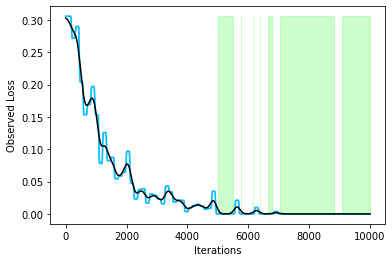

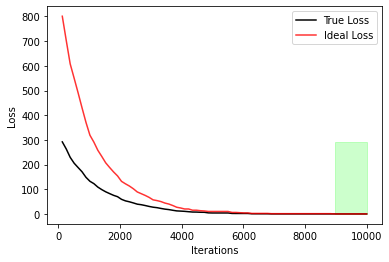

In [4]:
or_dim = 1000
or_dataset = ORDataset(or_dim, 10000, 1/or_dim, 0.1)
or_dataloader = DataLoader(or_dataset, batch_size=128, shuffle=True, num_workers=0)

or_model = FuzzyOR(or_dim, 1)
or_model.to('cuda')
or_ideal_model = ORIdealModel(or_dim)

or_items, or_losses, or_true_losses, or_ideal_losses = train_softop(or_model, or_dataloader, lr=1e-0, idealmodel=or_ideal_model)

plot_loss(or_items, or_losses, ylabel='Observed Loss', approx=True)
plot_loss(or_items, or_true_losses, ylabel='True Loss', ideal_losses=or_ideal_losses)

Learning `AND`.

  0%|          | 0/79 [00:00<?, ?it/s]

torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([128, 1000])
torch.Size([1000, 1]) torch.Size([

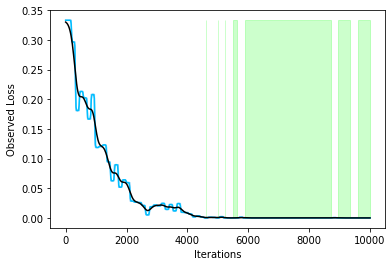

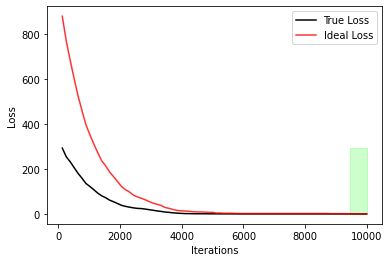

In [5]:
and_dim = 1000
and_dataset = ANDDataset(and_dim, 10000, 1-(1/and_dim), 0.01)
and_dataloader = DataLoader(and_dataset, batch_size=128, shuffle=True, num_workers=0)

and_model = FuzzyAND(and_dim, 1)
and_model.to('cuda')
and_ideal_model = ANDIdealModel(and_dim)

and_items, and_losses, and_true_losses, and_ideal_losses = train_softop(and_model, and_dataloader, lr=1e-0, idealmodel=and_ideal_model)

plot_loss(and_items, and_losses, ylabel='Observed Loss', approx=True)
plot_loss(and_items, and_true_losses, ylabel='True Loss', ideal_losses=and_ideal_losses)

Without bit hardening, we have sets of weights which all have equal loss, but with many not being represented by values $0, 1$. To counteract this, we apply bit hardening - the following shows the values of the weights inside each logic layer, which ideally are heavily skewed to the values $0,1$.

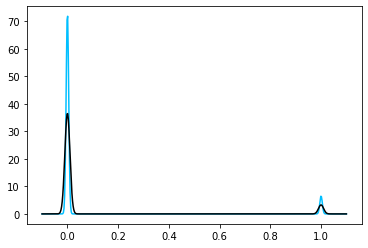

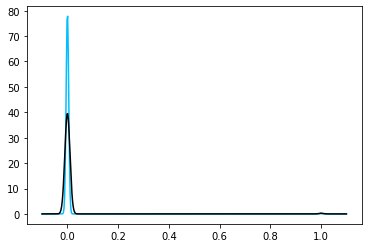

In [6]:
plot_bit_density(or_model.weights.cpu().detach())
plot_bit_density(and_model.weights.cpu().detach())

In [7]:
def train_dnf(model, dataloader, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr)

    seen = 0
    items = []
    obs_losses = []

    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to('cuda')
        y = y.to('cuda')
        pred = torch.squeeze(model(X))
        loss = ((pred - y)**2).mean()

        # Optimise NN model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.harden()

        seen += len(X)
        items.append(seen)
        obs_losses.append(loss.item())
        
    return torch.tensor(items), torch.tensor(obs_losses)

In [8]:
dnf_dim = 1
dnf_dataset = DNFDataset(dnf_dim, 5, 0.5, 10, 0.2, 0.5)
dnf_dataloader = DataLoader(dnf_dataset, batch_size=128, shuffle=True)

dnf_model = FuzzyDNF(dnf_dim, 1, 10)
dnf_model.to('cuda')

dnf_items, dnf_losses = train_dnf(dnf_model, dnf_dataloader, lr=1e-0)

plot_loss(dnf_items, dnf_losses, ylabel='Observed Loss', approx=True)
print(dnf_dataset.conj_sets)
print(dnf_dataset.disj_set)
print(dnf_dataset.X)

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([2, 10]) torch.Size([5, 2])


RuntimeError: The size of tensor a (10) must match the size of tensor b (5) at non-singleton dimension 1

# CHESS STUFF --------------------------------

In [ ]:
from chess_model.db.management.commands.train import xNNChess, ChessEvalDataset


In [ ]:
def train_chess(model, dataloader, max_batches):
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-1)
    size = len(dataloader.dataset)

    currs = []
    losses = []

    for batch, (X, y) in tqdm(enumerate(dataloader), total=min(max_batches, len(dataloader))):
        X = X.to('cuda')
        y = y.to('cuda')
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * len(X)
        currs.append(current)
        losses.append(loss)
            
    return torch.tensor(currs), torch.tensor(losses)

In [ ]:
chess_model = xNNChess(no_subnets=64, subnet_width=2)
chess_model.to('cuda')

chess_evals = ChessEvalDataset("evalmt.csv")
chess_dataloader = DataLoader(chess_evals, batch_size=64, shuffle=True, num_workers=0)

#chess_items, chess_losses = train_chess(chess_model, chess_dataloader, 10000)

#plot_loss(chess_items, chess_losses, approx=True)

In [ ]:
#plot_loss(chess_items, chess_losses, approx=True)

In [ ]:
torch.log(torch.tensor(0.1)) > float("-inf")

In [ ]:
or_model_test = SoftOR(5, 1)
or_model_test.weights

In [ ]:
loss = or_model_test(torch.tensor([1,1,1,1,1],dtype=torch.float32))

In [ ]:
loss